In [31]:
%pylab inline
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import timeit 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# ! pip install python-louvain

In [3]:
import networkx as nx
from networkx.algorithms.community.quality import modularity
import pycombo
import community as community_louvain

In [9]:
from typing import List

def _partition_sets(p:dict)->List[set]:
    '''converts partition as a dict of labels
    into list of sets of nodes
    '''
    P = dict()
    for k, v in p.items():
        P[v] = P.get(v, set())
        P[v].add(k)
    return list(P.values())

In [10]:
# ?modularity

# 1. Karate

In [11]:
G = nx.karate_club_graph()

In [12]:
partition1, mod = pycombo.execute(G, return_modularity=True, random_seed=42)
partition2 = community_louvain.best_partition(G)

In [17]:
mod

0.41978961209730403

In [13]:
p = _partition_sets(partition1)
modularity(G, p)

0.41978961209730437

In [14]:
p = _partition_sets(partition2)
modularity(G, p)

0.41880341880341876

In [15]:
%timeit pycombo.execute(G, return_modularity=True, random_seed=42)

792 µs ± 66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit community_louvain.best_partition(G)

2.59 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 2. Erdos-Reniy

In [35]:
Ns = [100, ] + list(range(200, 2100, 200))

In [22]:
RESULTS = dict()

for n in tqdm(Ns):
    G = nx.generators.random_graphs.erdos_renyi_graph(n=n, p=0.15, seed=42)
    
    
    partition1, mod = pycombo.execute(G, return_modularity=True, random_seed=42)
    partition2 = community_louvain.best_partition(G)
    p2 = _partition_sets(partition2)
    
    RESULTS[n] = {
        'combo': mod,
        'louvain': modularity(G, p2)
        
    }

 84%|████████▎ | 41/49 [9:46:23<1:54:25, 858.13s/it]  


KeyboardInterrupt: 

<AxesSubplot:>

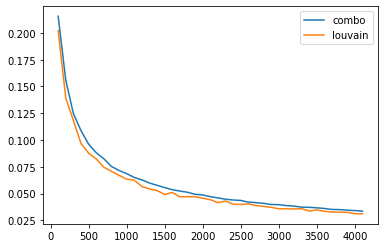

In [27]:
pd.DataFrame(RESULTS).T.plot()

In [53]:
import timeit 
    
  
# compute binary search time 
def combo_time(n:int): 
    SETUP_CODE = f''' 
from __main__ import pycombo
import networkx as nx
G = nx.generators.random_graphs.erdos_renyi_graph(n={n}, p=0.15, seed=42)
'''
  
    TEST_CODE = '''pycombo.execute(G, random_seed=42)'''
      
    # timeit.repeat statement 
    return timeit.repeat(setup = SETUP_CODE, 
                          stmt = TEST_CODE, 
                          repeat = 3, 
                          number = 1) 
    
def louvain_time(n:int): 
    SETUP_CODE = f''' 
import community as community_louvain
import networkx as nx
G = nx.generators.random_graphs.erdos_renyi_graph(n={n}, p=0.15, seed=42)
'''
  
    TEST_CODE = '''community_louvain.best_partition(G)'''
      
    # timeit.repeat statement 
    return timeit.repeat(setup = SETUP_CODE, 
                          stmt = TEST_CODE, 
                          repeat = 3, 
                          number = 1) 

In [64]:
from statistics import mean

In [65]:
PERF = {
    'combo': {},
    'louvain': {}
}

for n in tqdm(range(100, 1601, 100)):
    PERF['combo'][n] = mean(combo_time(n=n))
    PERF['louvain'][n] = mean(louvain_time(n=n))
    

100%|██████████| 16/16 [10:05<00:00, 37.87s/it]


<AxesSubplot:>

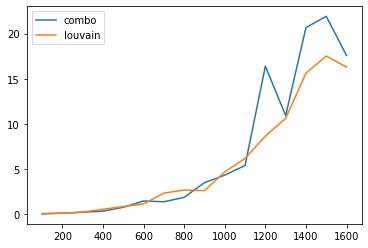

In [66]:
pd.DataFrame(PERF).plot()